Es wird entschieden keine der Spalten zu löschen, da diese für eine spätere Analyse möglicherweise wichtig sind.
Vielmehr sollen für die Durchführung des LDAs lediglich englische Lieder im Datensatz behalten werden.

In [1]:
# Importe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import gensim.corpora as corpora

In [2]:
# song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')

# song_data = song_data[(song_data['Language'] == 'en')]

# song_data.to_csv("outData.csv", index=False)

song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')

song_data_subset = song_data.head(100)

## Data Cleaning

In [3]:
# Remove the columns
song_data_subset = song_data_subset[['Genre', 'Lyrics']]
# Print out the first rows of papers
song_data_subset

,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...
...,...,...
95,Rock,We walk alone\nIn the unknown\nWe live to win ...
96,Rock,We walk alone\nIn the unknown\nWe live to win ...
97,Rock,Searching through my reasons to fight the tide...
98,Rock,"It starts with pain, followed by hate\nFueled ..."


## Remove punctuation/lower casing

In [4]:
# Remove punctuation
song_data_subset['song_text_processed'] = \
song_data_subset['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
song_data_subset['song_text_processed'] = \
song_data_subset['song_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
song_data_subset['song_text_processed'].head()

0    it starts with pain followed by hate\nfueled b...
1    freedom\nalone again again alone\npatiently wa...
2    biting the hand that feeds you lying to the vo...
3    you say you know just who i am\nbut you can't ...
4    my heart is beating faster can't control these...
Name: song_text_processed, dtype: object

## Analyse für ein Lied

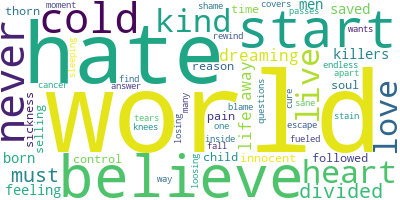

In [5]:
# Join the different processed titles together.
lyrics_for_one_song = song_data_subset.loc[0, 'song_text_processed']
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(lyrics_for_one_song)
# Visualize the word cloud
wordcloud.to_image()

In [32]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import pandas as pd
from pprint import pprint

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Assuming you have a DataFrame named 'songs_data' with a column 'lyrics'
song_data_subset['lyrics_processed'] = remove_stopwords(sent_to_words(song_data_subset['Lyrics']))

# Create a dictionary and a corpus for each song
corpora = []
dictionaries = []
lda_models = []
topics_words = []

num_topics = 5  # Change this to the desired number of topics

for i, song_lyrics in enumerate(song_data_subset['lyrics_processed']):
    # Create Dictionary
    id2word = gensim.corpora.Dictionary([song_lyrics])

    # Create Corpus
    corpus = [id2word.doc2bow(song_lyrics)]

    corpora.append(corpus)
    dictionaries.append(id2word)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lda_models.append(lda_model)

    # Get the most dominant topic for each song
    song_topics = lda_model.get_document_topics(corpus[0], minimum_probability=0.0)
    dominant_topic = max(song_topics, key=lambda x: x[1])[0]
    
    # Extract the words of the dominant topic
    topic_words = lda_model.print_topic(dominant_topic).split('"')[1::2]
    topics_words.append(topic_words)

    # Print the Keywords in the topics for the current song
    print(f"Keywords for Song {i + 1} - Topic {dominant_topic}: {', '.join(topic_words)}")

# Add the 'topics_words' column to the DataFrame
song_data_subset['topics_words'] = topics_words
song_data_subset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for Song 1 - Topic 3: world, hate, believe, never, cold, heart, live, dreaming, love, divided
Keywords for Song 2 - Topic 1: broken, know, away, need, cause, inside, heart, pain, take, deep
Keywords for Song 3 - Topic 0: given, take, lesson, life, listen, killing, find, self, inside, solution
Keywords for Song 4 - Topic 4: feeling, hearts, remember, thousand, feels, back, hell, see, still, take
Keywords for Song 5 - Topic 3: heart, beating, control, faster, feelings, enough, want, go, see, anymore
Keywords for Song 6 - Topic 0: feeling, thousand, back, hearts, feels, remember, still, take, see, pain
Keywords for Song 7 - Topic 0: back, give, away, nothing, mine, going, perfect, place, way, deep
Keywords for Song 8 - Topic 1: show, need, okay, father, mother, find, dreams, deeper, asleep, feet
Keywords for Song 9 - Topic 2: know, showed, stand, real, time, see, taught, behind, become, leavin
Keywords for Song 10 - Topic 1: stand, know, get, back, away, see, stay, mind, nothing,

,Genre,Lyrics,song_text_processed,lyrics_processed,topics,lyrics_processed_str,cluster,PCA_Feature_1,PCA_Feature_2,topics_words
0,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",0,starts pain followed hate fueled endless quest...,1,-0.030622,0.113733,"[world, hate, believe, never, cold, heart, liv..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...,freedom\nalone again again alone\npatiently wa...,"[freedom, alone, alone, patiently, waiting, ph...",0,freedom alone alone patiently waiting phone ho...,3,-0.042956,-0.499712,"[broken, know, away, need, cause, inside, hear..."
2,Rock,"Biting the hand that feeds you, lying to the v...",biting the hand that feeds you lying to the vo...,"[biting, hand, feeds, lying, voice, inside, re...",2,biting hand feeds lying voice inside reach beg...,1,-0.036410,0.053078,"[given, take, lesson, life, listen, killing, f..."
3,Rock,You say you know just who I am\nBut you can't ...,you say you know just who i am\nbut you can't ...,"[say, know, imagine, waits, across, line, thou...",3,say know imagine waits across line thought sti...,4,0.932307,-0.116657,"[feeling, hearts, remember, thousand, feels, b..."
4,Rock,My heart is beating faster can't control these...,my heart is beating faster can't control these...,"[heart, beating, faster, control, feelings, an...",4,heart beating faster control feelings anymore ...,3,-0.010195,0.124635,"[heart, beating, control, faster, feelings, en..."
...,...,...,...,...,...,...,...,...,...,...
95,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",1,walk alone unknown live win another victory yo...,0,-0.062920,0.124331,"[one, number, young, die, live, face, fight, f..."
96,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",3,walk alone unknown live win another victory yo...,0,-0.065963,0.122645,"[one, number, young, die, ones, face, live, ch..."
97,Rock,Searching through my reasons to fight the tide...,searching through my reasons to fight the tide...,"[searching, reasons, fight, tide, thing, works...",4,searching reasons fight tide thing works feeli...,3,-0.024792,0.053156,"[end, know, go, welcome, finally, reached, bac..."
98,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",1,starts pain followed hate fueled endless quest...,1,-0.030622,0.113733,"[world, believe, hate, never, cold, heart, lov..."


In [33]:
for i, topic in enumerate(topics):
    print(f"Song {i + 1} has dominant topic: {topic}")
    print(f"Keywords for Song {i + 1} - Topic {topic}:")
    pprint(lda_models[i].print_topics())
    print("\n")

Song 1 has dominant topic: 0
Keywords for Song 1 - Topic 0:
[(0,
  '0.056*"world" + 0.035*"hate" + 0.034*"believe" + 0.028*"cold" + '
  '0.025*"must" + 0.024*"kind" + 0.024*"love" + 0.024*"never" + 0.024*"heart" '
  '+ 0.023*"away"'),
 (1,
  '0.052*"world" + 0.028*"believe" + 0.024*"hate" + 0.023*"cold" + '
  '0.023*"must" + 0.022*"never" + 0.022*"life" + 0.021*"heart" + '
  '0.021*"divided" + 0.020*"kind"'),
 (2,
  '0.030*"world" + 0.022*"believe" + 0.021*"life" + 0.021*"hate" + '
  '0.020*"cold" + 0.020*"kind" + 0.020*"away" + 0.019*"heart" + 0.018*"never" '
  '+ 0.018*"love"'),
 (3,
  '0.074*"world" + 0.035*"hate" + 0.034*"believe" + 0.034*"never" + '
  '0.031*"cold" + 0.028*"heart" + 0.028*"live" + 0.027*"dreaming" + '
  '0.026*"love" + 0.025*"divided"'),
 (4,
  '0.064*"world" + 0.038*"hate" + 0.037*"believe" + 0.030*"cold" + '
  '0.030*"never" + 0.028*"divided" + 0.027*"away" + 0.027*"kind" + '
  '0.026*"life" + 0.026*"love"')]


Song 2 has dominant topic: 0
Keywords for Song 2 - 

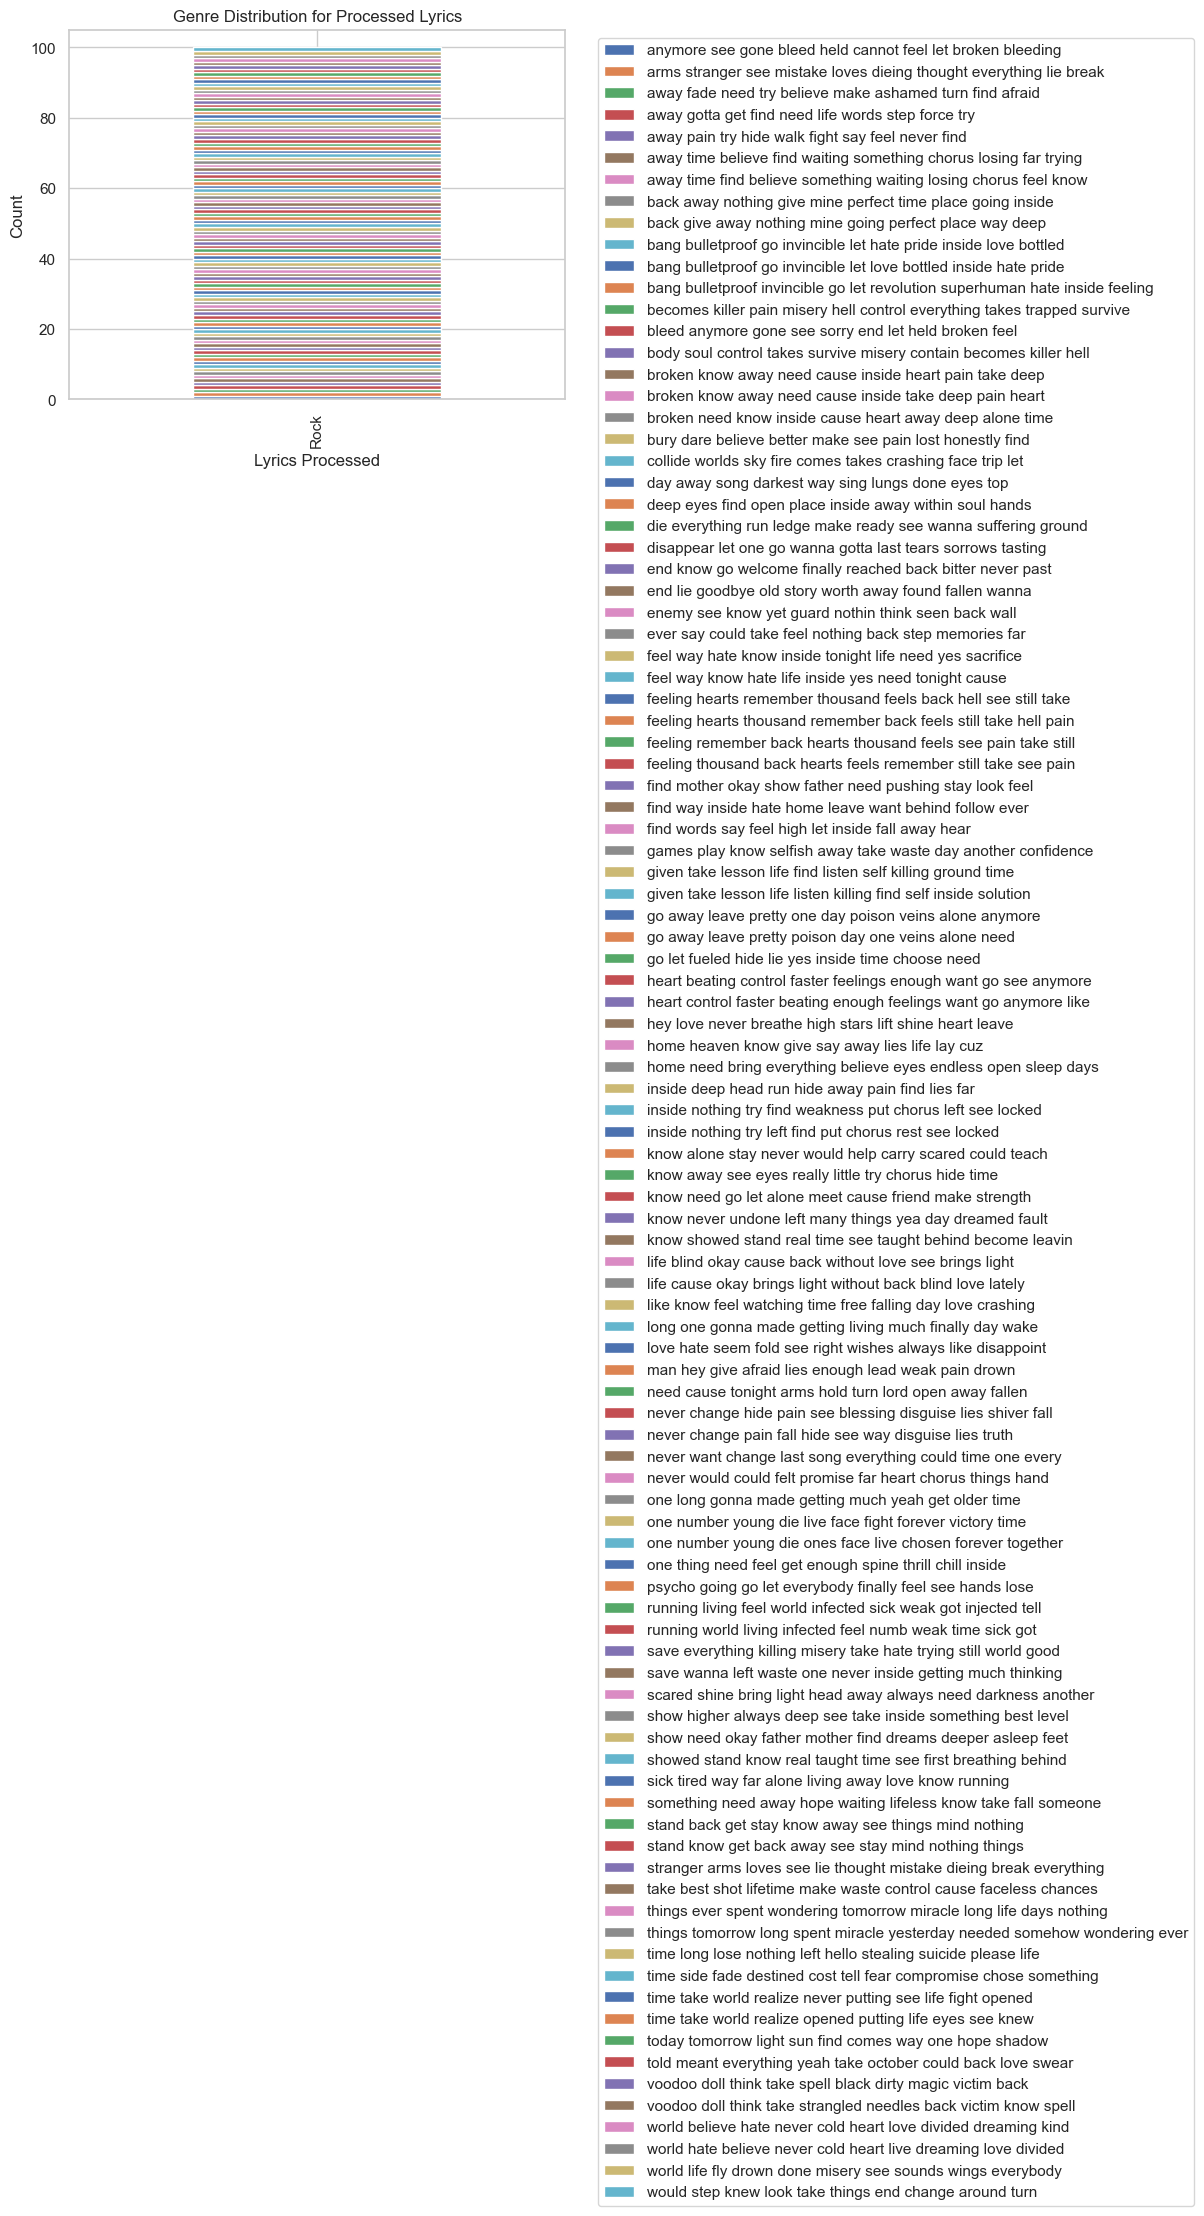

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'lyrics_processed' column contains lists of words
song_data_subset['lyrics_processed_str'] = song_data_subset['topics_words'].apply(lambda x: ' '.join(x))

# Create a crosstab
crosstab = pd.crosstab(song_data_subset['Genre'], song_data_subset['lyrics_processed_str'])

# Plot the crosstab
crosstab.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Lyrics Processed')
plt.ylabel('Count')
plt.title('Genre Distribution for Processed Lyrics')
plt.show()

c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sdo\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


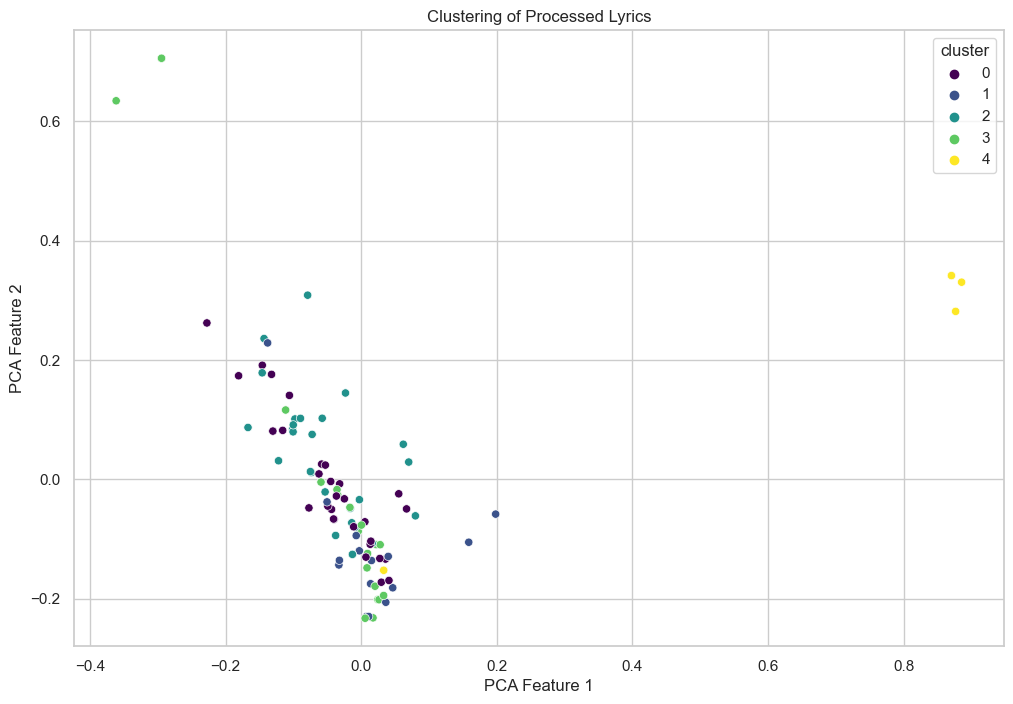

,Genre,Lyrics,song_text_processed,lyrics_processed,topics,lyrics_processed_str,cluster,PCA_Feature_1,PCA_Feature_2,topics_words
0,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",0,world hate believe never cold heart live dream...,1,-0.032782,-0.143565,"[world, hate, believe, never, cold, heart, liv..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...,freedom\nalone again again alone\npatiently wa...,"[freedom, alone, alone, patiently, waiting, ph...",0,broken know away need cause inside heart pain ...,3,-0.294348,0.705718,"[broken, know, away, need, cause, inside, hear..."
2,Rock,"Biting the hand that feeds you, lying to the v...",biting the hand that feeds you lying to the vo...,"[biting, hand, feeds, lying, voice, inside, re...",2,given take lesson life listen killing find sel...,1,-0.002595,-0.119889,"[given, take, lesson, life, listen, killing, f..."
3,Rock,You say you know just who I am\nBut you can't ...,you say you know just who i am\nbut you can't ...,"[say, know, imagine, waits, across, line, thou...",3,feeling hearts remember thousand feels back he...,4,0.876763,0.281442,"[feeling, hearts, remember, thousand, feels, b..."
4,Rock,My heart is beating faster can't control these...,my heart is beating faster can't control these...,"[heart, beating, faster, control, feelings, an...",4,heart beating control faster feelings enough w...,3,-0.004678,-0.083284,"[heart, beating, control, faster, feelings, en..."
...,...,...,...,...,...,...,...,...,...,...
95,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",1,one number young die live face fight forever v...,0,0.029780,-0.172516,"[one, number, young, die, live, face, fight, f..."
96,Rock,We walk alone\nIn the unknown\nWe live to win ...,we walk alone\nin the unknown\nwe live to win ...,"[walk, alone, unknown, live, win, another, vic...",3,one number young die ones face live chosen for...,0,0.041074,-0.169568,"[one, number, young, die, ones, face, live, ch..."
97,Rock,Searching through my reasons to fight the tide...,searching through my reasons to fight the tide...,"[searching, reasons, fight, tide, thing, works...",4,end know go welcome finally reached back bitte...,3,0.000440,-0.076742,"[end, know, go, welcome, finally, reached, bac..."
98,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...",1,world believe hate never cold heart love divid...,1,-0.032032,-0.135804,"[world, believe, hate, never, cold, heart, lov..."


In [39]:
from sklearn.decomposition import PCA

# Assuming 'lyrics_processed' column contains lists of words
song_data_subset['lyrics_processed_str'] = song_data_subset['topics_words'].apply(lambda x: ' '.join(x))

# Vectorize the lyrics using TF-IDF
X = vectorizer.transform(song_data_subset['lyrics_processed_str'])

# Apply PCA to reduce dimensionality to 2 features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add PCA features to DataFrame
song_data_subset['PCA_Feature_1'] = X_pca[:, 0]
song_data_subset['PCA_Feature_2'] = X_pca[:, 1]

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA_Feature_1', y='PCA_Feature_2', hue='cluster', palette='viridis', data=song_data_subset)
plt.title('Clustering of Processed Lyrics')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

song_data_subset
